# CPS Example

Have teachers become more likely to have summer jobs?

In [1]:
import numpy as np
import pandas as pd
import os

os.chdir('data/clean')

import matplotlib.pyplot as plt

plt.rc('font', family='Lato', weight=3)

### Latest month example

In [2]:
cps_file_2019 = 'cps2019.ft'

teacher_occs = [2300, 2310, 2320, 2330, 2340]
teacher = lambda x: np.where((x['IND'] == 7860) &
                             (x['OCC'].isin(teacher_occs)), 1, 0)

teacher_occs80 = [155, 156, 157, 158, 159]
teacher80 = lambda x: np.where((x['IND80'] == 842) &
                               (x['OCC80'].isin(teacher_occs80)), 1, 0)

columns = ['CPSID', 'YEAR', 'MONTH', 'AGE', 'FEMALE', 'EDUC', 'PULINENO',
           'WBHAO', 'LFS', 'WORKFT', 'IND', 'OCC', 'HRSACT1', 'HRSACTT',
           'OCC80', 'IND80', 'HRSUSL1', 'HRSUSLT', 'MJH', 'BASICWGT']

In [3]:
df = (pd.read_feather(cps_file_2019, columns=columns)
        .query('BASICWGT > 0')
        .assign(TEACHER = teacher))

nov_2019_data = df.query('MONTH == 11')

In [4]:
population = nov_2019_data.BASICWGT.sum()
employed = nov_2019_data.query('LFS == "Employed"').BASICWGT.sum()

teachers = (nov_2019_data.query('TEACHER == 1').BASICWGT.sum())

print(f'Population (15+): {round(int(population), -3):,.0f}')
print(f'Employed: {round(int(employed), -3):,.0f}')
print(f'Teachers: {round(int(teachers), -3):,.0f}')

Population (15+): 260,020,000
Employed: 158,945,000
Teachers: 5,588,000


### Trend over time

In [5]:
full_data = (pd.concat([pd.read_feather(f'cps{year}.ft', columns=columns)
                          .query('BASICWGT > 0').assign(TEACHER = teacher80)
                        for year in range(1997, 2000)], sort=False)
               .append([pd.read_feather(f'cps{year}.ft', columns=columns)
                          .query('BASICWGT > 0').assign(TEACHER = teacher)
                        for year in range(2000, 2020)], sort=False))

In [6]:
emp_ts = (full_data.query('LFS == "Employed"').groupby(['YEAR', 'MONTH']).BASICWGT.sum())
emp_ts.index = pd.to_datetime(emp_ts.index.map('{0[0]}-{0[1]}-01'.format))
tchr_ts = (full_data.query('TEACHER == 1')
           .groupby(['YEAR', 'MONTH']).BASICWGT.sum())
tchr_ts.index = pd.to_datetime(tchr_ts.index.map('{0[0]}-{0[1]}-01'.format))

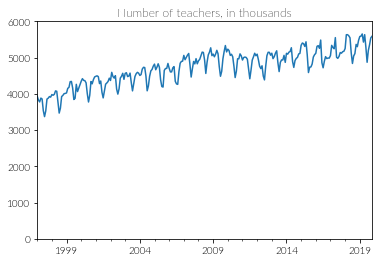

In [7]:
title = 'Number of teachers, in thousands'
tchr_ts.divide(1000).plot(title=title, ylim=(0,6000));

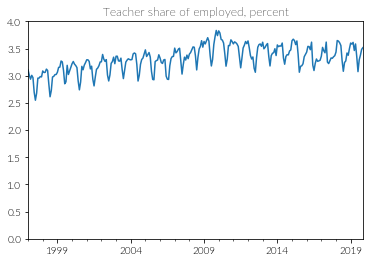

In [8]:
title = 'Teacher share of employed, percent'
tchr_ts.divide(emp_ts).multiply(100).plot(title=title, ylim=(0,4));

In [9]:
full_data['HOURS'] = full_data['HRSACT1'] * full_data['BASICWGT']

emp_hrs_ts = (full_data.query('HOURS > 0 and LFS == "Employed"').groupby(['YEAR', 'MONTH']).HOURS.sum())
emp_hrs_ts.index = pd.to_datetime(emp_hrs_ts.index.map('{0[0]}-{0[1]}-01'.format))

tchr_hrs_ts = (full_data.query('HOURS > 0 and TEACHER == 1')
               .groupby(['YEAR', 'MONTH']).HOURS.sum())
tchr_hrs_ts.index = pd.to_datetime(tchr_hrs_ts.index.map('{0[0]}-{0[1]}-01'.format))

trend = tchr_hrs_ts.divide(emp_hrs_ts).multiply(100)

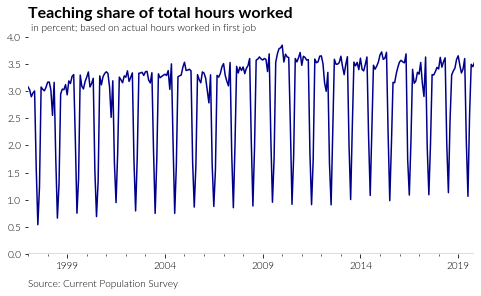

In [10]:
title = 'Teaching share of total hours worked'
trend.plot(ylim=(0,4), figsize=(8, 4), color='darkblue')
plt.text(pd.to_datetime('1997-01-01'), 4.35, title, fontsize=16, weight='bold')
plt.text(pd.to_datetime('1997-03-01'), 4.12, 'in percent; based on actual hours worked in first job')
plt.text(pd.to_datetime('1997-01-01'), -0.6, 'Source: Current Population Survey')
plt.axhline(0, color='lightgray')
plt.box(on=None)
plt.savefig('teacher_trend.png', bbox_inches='tight')
plt.show();

In [11]:
xlim = (pd.to_datetime('1996-12-01'), pd.to_datetime('2019-12-31'))

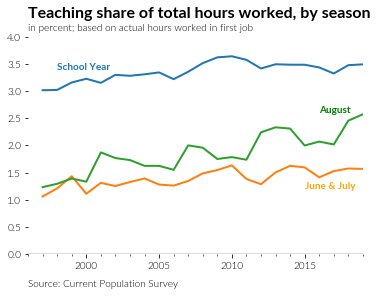

In [12]:
title = 'Teaching share of total hours worked, by season'
data = pd.DataFrame()
data['school_year'] = trend.loc[trend.index.month.isin([1,2,3,4,5,9,10,11,12])].resample('A').mean()
data['June_and_July'] = trend.loc[trend.index.month.isin([6,7])].resample('A').mean()
data['August'] = trend.loc[trend.index.month.isin([8])].resample('A').mean()
data.plot(ylim=(0,4), xlim=xlim, lw=2, legend=False)
plt.box(on=None)
plt.text(pd.to_datetime('1996-03-01'), 4.35, title, fontsize=16, weight='bold')
plt.text(pd.to_datetime('1996-09-01'), 4.12, 'in percent; based on actual hours worked in first job')
plt.text(pd.to_datetime('1996-03-01'), -0.6, 'Source: Current Population Survey')
plt.axhline(0, color='lightgray')
plt.text(pd.to_datetime('1998-01-01'), 3.4, 'School Year', color='C0', weight='bold')
plt.text(pd.to_datetime('2016-06-01'), 2.6, 'August', color='green', weight='bold')
plt.text(pd.to_datetime('2015-01-01'), 1.2, 'June & July', color='orange', weight='bold')
plt.savefig('teacher_trend_season.png', bbox_inches='tight')
plt.show();

### CPS Matching

In [13]:
match_mos = [(6, 3), (6, 4), (7, 4), (6, 5), (7, 5), (8, 5), (6, 9), (7, 9), 
             (7, 10), (8, 9), (8, 10), (8, 11)]

merged_teacher_data = pd.DataFrame()

for year in range(1997, 2020):
    df = full_data.query('YEAR == @year')
    for summer_mo, sch_yr_mo in match_mos:
        summer_data = df.query('MONTH == @summer_mo')
        sch_yr_data = df.query('MONTH == @sch_yr_mo')

        m = pd.merge(summer_data, sch_yr_data, 
                     on=['CPSID', 'PULINENO'], how='inner')
        m = m[(m['WBHAO_x'] == m['WBHAO_y']) &
              (m['FEMALE_x'] == m['FEMALE_y']) &
              (m['AGE_y'] >= m['AGE_x']) &
              (m['AGE_x'] <= m['AGE_y'] + 1)]

        t = m.query('TEACHER_y == 1')

        merged_teacher_data = merged_teacher_data.append(t)

In [14]:
categories = (
    lambda x: 
    np.where((x['TEACHER_x'] == 1) & (x['HRSACT1_x'] > 0), 
        'Teacher, at work',
    np.where((x['TEACHER_x'] == 1) & (x['HRSACTT_x'] < 1), 
        'Teacher, not at work',
    np.where((x['MJH_x'] == 1) | (x['LFS_x'] == 'Employed'), 
        'Other/second job',
    'Not employed'))))

In [15]:
result = (merged_teacher_data
          .assign(CATEGORY = categories)
          .groupby(['YEAR_x', 'CATEGORY'])
          .BASICWGT_y.sum().unstack())

data = (result.divide(result.sum(axis=1), axis=0) * 100)

data.index = pd.to_datetime(data.index, format='%Y')
del data.index.name

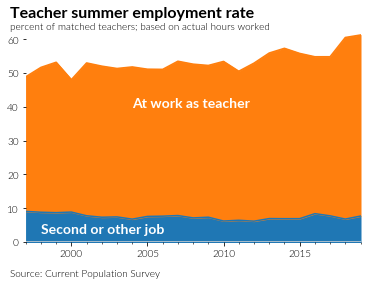

In [16]:
title = 'Teacher summer employment rate'
data[['Other/second job', 'Teacher, at work']].plot(kind='area', legend=False)
plt.box(on=None)
plt.text(pd.to_datetime('1996-03-01'), 66.5, title, fontsize=16, weight='bold')
plt.text(pd.to_datetime('1996-09-01'), 63, 'percent of matched teachers; based on actual hours worked')
plt.text(pd.to_datetime('1996-03-01'), -10, 'Source: Current Population Survey')
plt.axhline(0, color='lightgray')
plt.text(pd.to_datetime('2004-01-01'), 40, 'At work as teacher', color='white', fontsize=14, weight='bold')
plt.text(pd.to_datetime('1998-06-01'), 2.5, 'Second or other job', color='white', fontsize=14, weight='bold')
plt.savefig('teacher_summer_share.png', bbox_inches='tight')
plt.show();